In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import os
import sys
import datetime as dt
import glob 
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import matplotlib.dates as mdates



lat_oo = 35.49
lon_oo = 12.47


CCMP READING AND EXTRACTION
---

In [ ]:
#read ccmp data


#add the path for the CCMP data downloaded from www.remss.com
ccmp_dir = " "

#i have data divided in years and months folders

years = ["2021","2022","2023"]
months = ["M01", "M02", "M03", "M04", "M05", "M06", "M07", "M08", "M09", "M10", "M11", "M12"]
filenames = []


for year in years:
    for month in months:
        path = ccmp_dir + year + "/" + month +"/"
        #print(path)
        if os.path.exists(path):
            filenames.append(sorted(glob.glob(ccmp_dir + year + "/" + month +"/"+"*.nc")))


dfs = []

for fn in filenames:
    for f in fn:
        file_in = xr.open_dataset(f)
        df = file_in.sel(latitude=lat_oo, longitude=lon_oo, method='nearest').to_dataframe()
        dfs.append(df)

ccmp_df = pd.concat(dfs)

ccmp_df.sort_index(inplace = True)

ccmp_df.reset_index(inplace = True)



#i save in csv to make easier the use of the point-like data
#ccmp_df.to_csv("./ccmp_df.csv", index = None)

READING INSITU DATA
---

In [2]:
#first read ccmp csv
#ccmp_df = pd.read_csv("./ccmp_df.csv", converters={'time': pd.to_datetime})

In [3]:
#2hrs corrected buoy data with errors on pco2 corrected 
#insitu data
buoy_data = pd.read_csv("", converters= {'date': pd.to_datetime})

#specify converters for float data, discard ufloat formatted data
for col in buoy_data.columns:
    if col not in ["date", "co2_w_err", "pco2_w_err"]:
        buoy_data[col].astype(float)

buoy_data.drop(columns = ["co2_w_err", "pco2_w_err"], inplace = True)

In [4]:
#wind hourly data
#path to insitu data
insitu_wind_dir = ""

filenames = glob.glob(insitu_wind_dir + "meth*")

dfs = []

for fnames in sorted(filenames):
    dfs.append(pd.read_csv(fnames, na_values = ["///", "/////", "//////"]))
               
meteo = pd.concat(dfs)

meteo.dropna(inplace = True)
meteo.reset_index(inplace = True, drop = True)


#convert to datetime
#I round to the exact hour (00.30 = 00.00) to manage easily
meteo["date"]  = meteo.apply(lambda x: dt.datetime(int(x.year), int(x.month), int(x.day), int(x.hour)), axis = 1)

#i only need wind speed  and pressure, throw away the rest
meteo = meteo[["date", "p(mbar)", "u(m/s)"]]

meteo[["u(m/s)", "p(mbar)"]].astype(float)

#average over 6h, i need to define time index and bla bla
meteo_6h = meteo.set_index("date").resample("6H").mean()

#I count the number of available data
meteo_6h['n_obs'] = meteo.set_index("date").resample("6H").count()["u(m/s)"]
meteo_6h.reset_index(inplace = True)


#i discard nan and 6-h averag with n_obs  < 5
meteo_6h = meteo_6h[meteo_6h["n_obs"] >= 5]

#and ccmp wind data with AT LEAST 1 observation
ccmp_df = ccmp_df[ccmp_df.nobs > 0]

#from ccmp i only need wind speed, time and number of observations, drop the rest
#some dates (10 total) are with nan on the uwnd and wvnd and have u v and w values.. i don't know what to do with them, so i drop them (what is w?) and they have a huge n_obs value (why?)

ccmp_df = ccmp_df[["time", "uwnd", "vwnd", "nobs"]]

#drop nan
ccmp_df.dropna(inplace = True)

#and rename time to date
ccmp_df.rename(columns = {"time": "date"}, inplace = True)
#i compute wind speed from u and v components using pythagoras
ccmp_df["wspd"] = np.sqrt(ccmp_df["uwnd"]**2 + ccmp_df["vwnd"]**2)

#i now merge insitu (meteo_6h) and ccmp data to compare them
wind = pd.merge(meteo_6h, ccmp_df, on= "date", how = "inner")

plots

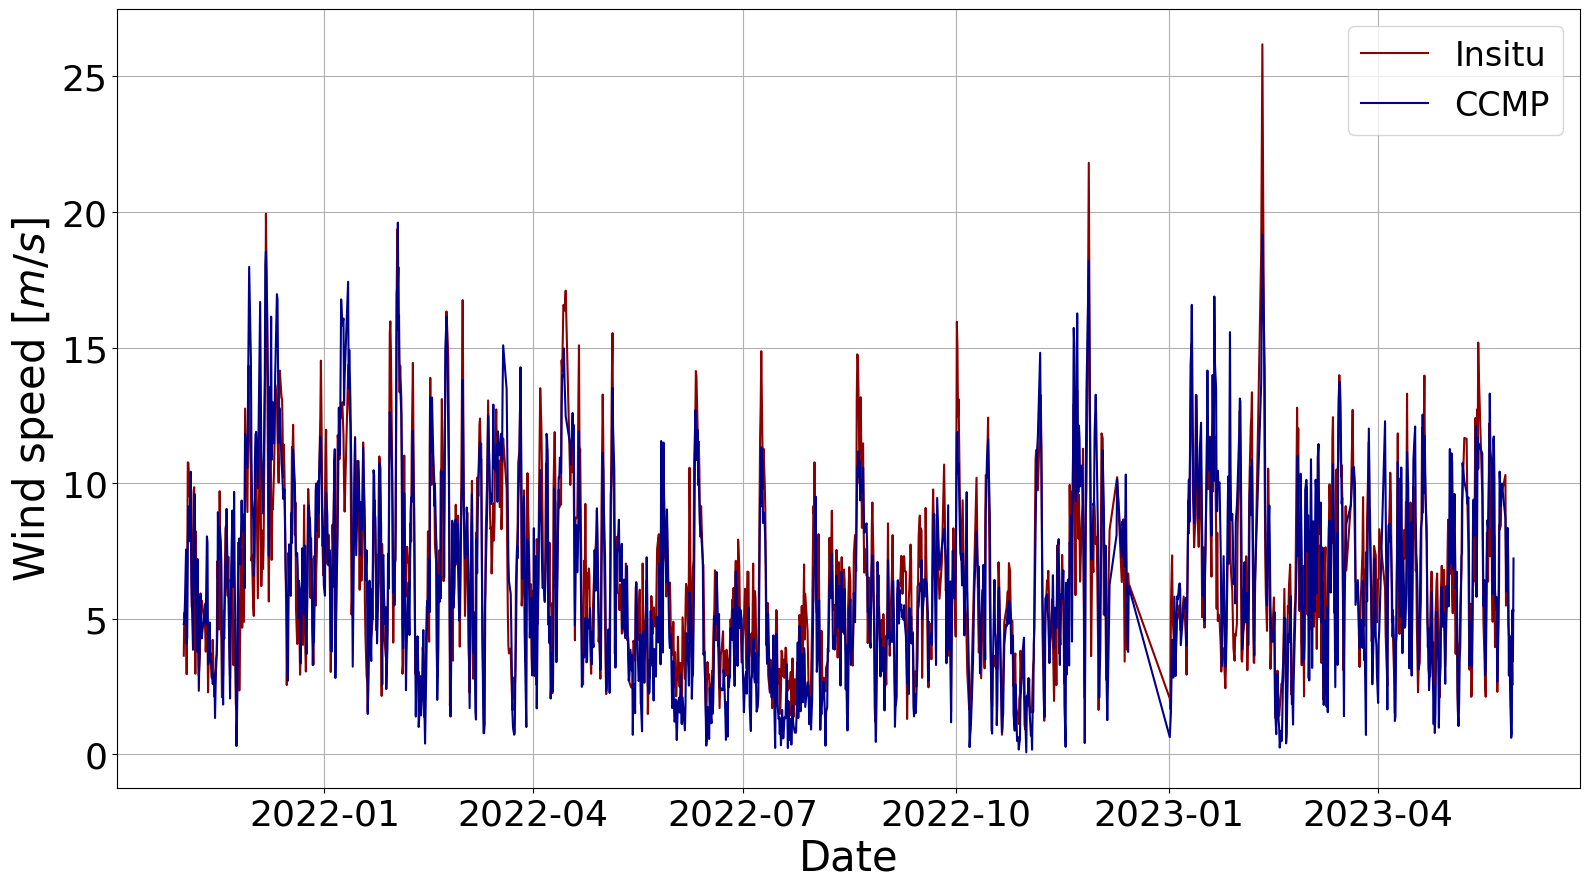

In [26]:
#plotto mod4 6 9log con T2 vs senza T2 Seasonal vs seasonal

fig = plt.figure(figsize= (16,9))
ax = plt.axes()

plt.plot(wind["date"], wind["u(m/s)"], label = "Insitu", color = "darkred")
plt.plot(wind["date"], wind["wspd"], label = "CCMP", color = "darkblue")


ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday = 1, interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.ylabel(r"Wind speed $\left[m/s \right]$", fontsize = 30)
plt.xlabel("Date", fontsize = 30)
plt.tick_params(axis='both', which='both', labelsize=26, rotation = 0)


plt.grid()
plt.legend(fontsize = 24)




plt.tight_layout()

plt.savefig("./Figure4.jpg", format = "jpg")

#plt.close()


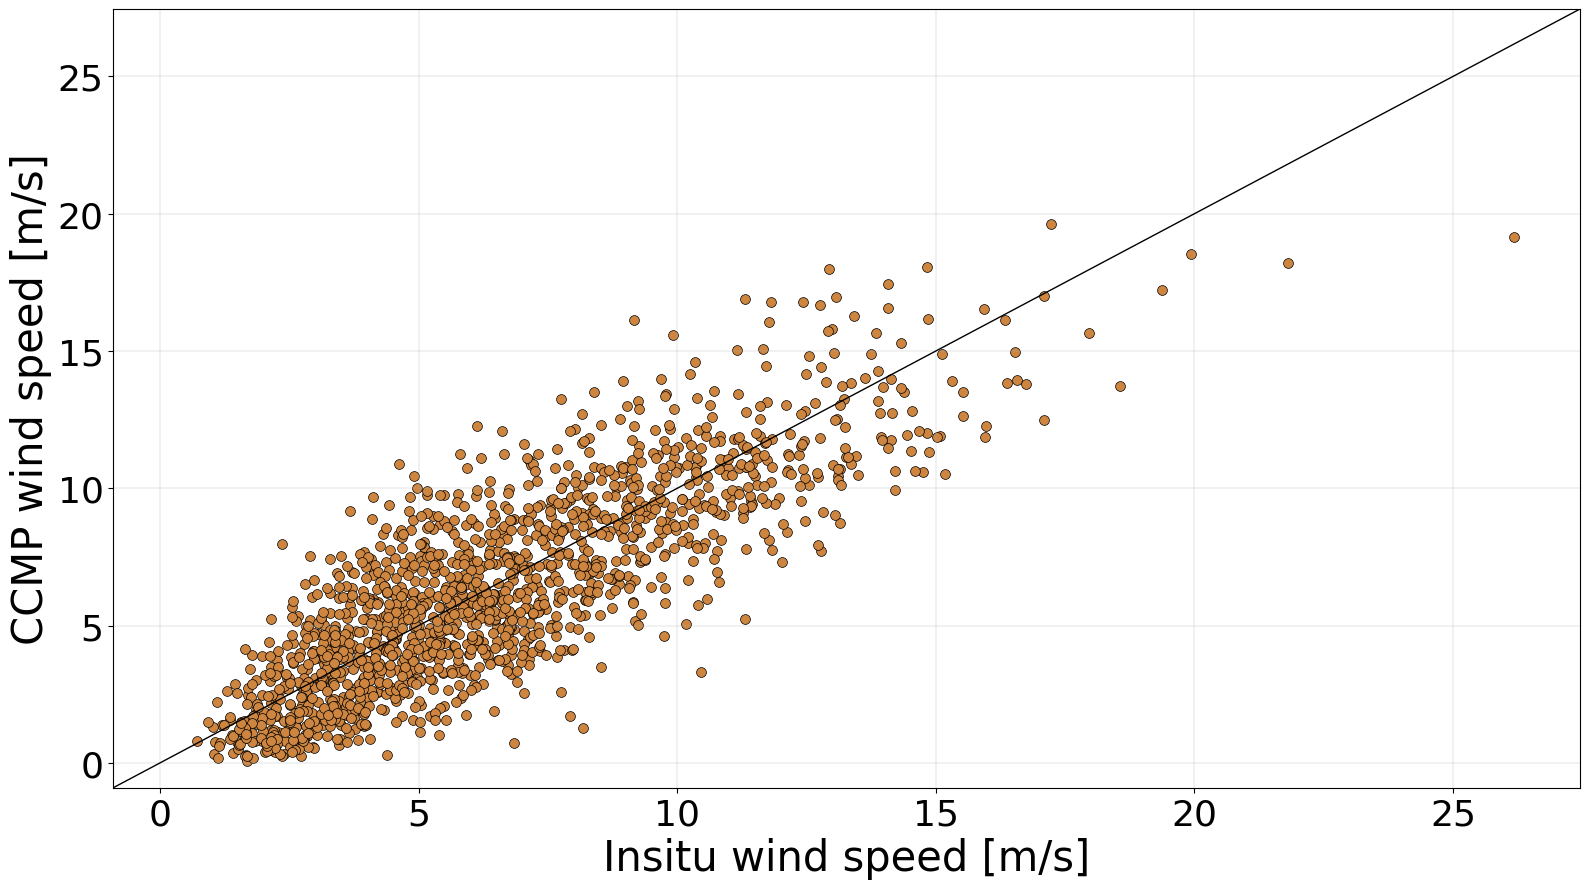

In [27]:
#ßcatter plot normale senza inverntrmi punti di densità

#scatter plot

fig = plt.figure(figsize=(16, 9))
ax = plt.axes()

plt.scatter(wind["u(m/s)"], wind["wspd"], s=50, c = "peru", edgecolors='k', linewidths=0.5)

plt.xlabel("Insitu wind speed [m/s]", fontsize = 30)
plt.ylabel("CCMP wind speed [m/s]", fontsize = 30)

#plt.legend(fontsize = 12, loc = "upper left", ncol = 2)


#åggiungo la diagonale 1:1
#metto i limiti uguali su x e y
min_value = np.min([ax.get_xlim()[0], ax.get_ylim()[0]])
max_value = np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
plt.tick_params(axis='both', which='both', labelsize=26)


ax.plot([min_value, max_value], [min_value, max_value], color = "black", linewidth = 1)

#setto i limiti uguali in modo che la diaognale 1:1 sia quadrata
ax.set_xlim(min_value, max_value)
ax.set_ylim(min_value, max_value)

plt.grid(lw = 0.25)

plt.tight_layout()

plt.savefig("./Figure5.jpg", format = "jpg")



In [125]:
#due statistiche

bias = np.mean(wind["wspd"]-wind["u(m/s)"])
rmse = np.sqrt(mean_squared_error(wind["wspd"], wind["u(m/s)"]))
r2 = r2_score(wind["wspd"], wind["u(m/s)"])
r2_2 = pearsonr(wind["wspd"], wind["u(m/s)"])[0]**2
p = pearsonr(wind["wspd"], wind["u(m/s)"])[1]

print("Bias: ", bias, "RMSE: ", rmse, "R2: ", r2, "R2_2: ", r2_2, "p: ", p, "N: ", len(wind))

Bias:  -0.14326074569297906 RMSE:  2.0363070172381827 R2:  0.6839300093516902 R2_2:  0.6952937540933755 p:  0.0 N:  1596
